In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# data prep and model-tuning
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, QuantileTransformer
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# types of models we'll fit
from sklearn.linear_model import ElasticNetCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

import pickle
from copy import deepcopy

## Our Data

In [3]:
DATA = '../data/processed/training_data_annual.csv'
df = pd.read_csv(DATA)
df = df.dropna()
print('{:,d} samples'.format(len(df)))
print('Columns:', df.columns.values)

4,721 samples
Columns: ['uuid' 'lidar_year' 'lat' 'lon' 'orig_id' 'source' 'meas_yr' 'ecoregion3'
 'agency' 'plot_size_ac' 'num_returns' 'strat0_return-proportion'
 'strat1_return-proportion' 'strat2_return-proportion'
 'strat3_return-proportion' 'strat4_return-proportion'
 'strat5_return-proportion' 'strat0_intensity-median'
 'strat1_intensity-median' 'strat2_intensity-median'
 'strat3_intensity-median' 'strat4_intensity-median'
 'strat5_intensity-median' 'height_05-percentile' 'height_25-percentile'
 'height_50-percentile' 'height_75-percentile' 'height_95_percentile'
 'height_max' 'cover' 'lidar_acq' 'potential_volume' 'stddev_height'
 'surface_area_ratio' 'surface_volume' 'surface_volume_ratio' 'aspect'
 'elevation' 'overall_curvature' 'plan_curvature' 'profile_curvature'
 'slope' 'solar_radiation_index' 'mat' 'mwmt' 'mcmt' 'td' 'map' 'msp'
 'ahm' 'shm' 'dd_0' 'dd5' 'dd_18' 'dd18' 'nffd' 'bffp' 'effp' 'ffp' 'pas'
 'emt' 'ext' 'eref' 'cmd' 'rh' 'green' 'blue' 'red' 'nir' 'endvi' 'nd

## Filter out some of the training data
We can exclude some of the training data based on how far separated the inventory data (interpolated using FVS simulations) is from the year the lidar was collected. Similarly, we can screen out training examples that had relatively low density of lidar returns.

In [4]:
df['year_diff'] = abs(df['fvs_year'] - df['lidar_year']).astype(int)
df = df.loc[df['year_diff'] < 10]
df = df.loc[df['returns_per_m2'] >= 4.0]

## Inspect how many samples we have for different years, regions, etc.

In [5]:
df.groupby(by=['lidar_year'])[['uuid']].count().rename({'uuid':'count'}, axis=1)

,count
lidar_year,
2006,191
2008,857
2009,113
2010,21
2011,161
2012,720
2013,269
2014,368
2015,680


In [6]:
pd.pivot_table(df, 
               values='uuid', 
               aggfunc='count', 
               index=['meas_yr'], 
               columns=['lidar_year'], 
               fill_value=0)

lidar_year,2006,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
meas_yr,,,,,,,,,,,,
2010,0,475,0,0,0,4,0,2,7,0,0,0
2011,0,377,0,0,0,1,0,2,3,0,0,0
2013,168,0,18,0,37,466,54,6,11,14,28,2
2014,5,0,60,2,28,132,45,50,44,99,40,1
2015,18,4,5,0,55,18,13,16,217,114,25,6
2016,0,1,18,15,26,45,90,59,284,77,36,26
2017,0,0,9,2,12,44,43,182,58,104,51,0
2018,0,0,3,2,3,10,24,51,56,196,11,0


In [7]:
ecoreg_counts = df.groupby(by=['ecoregion3'])[['uuid']].count()
ecoreg_counts

,uuid
ecoregion3,
blue_mountains,108
cascades,747
coast_range,1809
columbia_plateau,14
eastern_cascades_slopes_and_foothills,409
klamath_mountains_california_high_north_coast_range,323
north_cascades,505
northern_rockies,103
puget_lowland,149


## Available features
First, we'll use one-hot encoding for categorical features

In [8]:
# convert agency, ecoregion, and lidar acquisition into one-hot encoded set of variables
df = pd.get_dummies(df, prefix='agency', columns=['agency'])
# df = pd.get_dummies(df, prefix='eco', columns=['ecoregion3'])
# df = pd.get_dummies(df, prefix='acq', columns=['lidar_acq'])

The different types of predictor variables we can use to predict a forest attribute, including climate, lidar-derived, soil, and satellite imagery.

In [9]:
CLIM_COLS = ['mat', 'mwmt', 'mcmt', 'td', 'map', 'msp', 'ahm', 'shm', 
             'dd_0', 'dd5', 'dd_18', 'dd18', 'nffd', 'bffp', 'effp', 
             'ffp', 'pas', 'emt', 'ext', 'eref', 'cmd', 'rh']
LIDAR_COLS = ['returns_per_m2', 'strat0_return-proportion',
       'strat1_return-proportion', 'strat2_return-proportion',
       'strat3_return-proportion', 'strat4_return-proportion',
       'strat5_return-proportion', 'strat0_intensity-median',
       'strat1_intensity-median', 'strat2_intensity-median',
       'strat3_intensity-median', 'strat4_intensity-median',
       'strat5_intensity-median', 'height_05-percentile',
       'height_25-percentile', 'height_50-percentile', 'height_75-percentile',
       'height_95_percentile', 'height_max', 'cover', 'potential_volume',
       'stddev_height', 'surface_area_ratio', 'surface_volume',
       'surface_volume_ratio', 'aspect', 'elevation', 'overall_curvature',
       'plan_curvature', 'profile_curvature', 'slope', 'solar_radiation_index']

SOIL_COLS = ['bulk_dens', 'soil_depth', 'pct_clay_surf', 'pct_rock_surf', 'pct_sand_surf']

LANDSAT_COLS = ['green', 'blue', 'red', 'nir', 'endvi', 'ndvi', 'savi',
                'swir1', 'swir2', 'wetness', 'greenness', 'brightness']

AGENCY_COLS = ['agency_BLM', 'agency_USFS', 'agency_WADNR']

# ECOREGIONS = [col for col in df.columns if col.startswith('eco_')]

## Selecting initial features and targets
This is the first step in determining what features we want to use, and what we want to predict. Later, we can still apply some procedures to choose a subset of these features to make simpler models.

In [10]:
X_COLS = LIDAR_COLS + ['plot_size_ac', 'ecoregion3'] + LANDSAT_COLS + CLIM_COLS
Y_COLS = ['tcuft']

## Split the data into training and testing sets
Since some plot_ids have multiple observations, we want all observations for each plot_id to fall entirely in train_set or entirely the training or testing sets because these samples are definitely not independent.

In [11]:
# a dataframe with unique plot ids
splits = pd.DataFrame(pd.unique(df['uuid']), columns=['uuid']).set_index('uuid')

# randomly assign each plot-id to train(0) or test(1) sets
np.random.seed(127)
splits['train0_test1'] = np.random.choice(2,
                                          size=len(splits),
                                          p=[0.8,0.2])

# add set assignments to the dataframe
df['train0_test1'] = splits.loc[df['uuid']]['train0_test1'].values

In [12]:
train_plots = df.loc[df['train0_test1'] == 0]
test_plots = df.loc[df['train0_test1'] == 1]
len(train_plots), len(test_plots)

(3355, 855)

In [13]:
x_train, x_test = train_plots[X_COLS].reset_index(drop=True), test_plots[X_COLS].reset_index(drop=True)
y_train, y_test = train_plots[Y_COLS].reset_index(drop=True), test_plots[Y_COLS].reset_index(drop=True)

## Standardize features
Scale all predictive features to have 0 mean and unit variance (subtracting mean, dividing by standard deviation).

In [14]:
x_scaler = StandardScaler()
x_scaler.fit(df[X_COLS].drop(['ecoregion3'], axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

## Consider a few transformations for the target variable

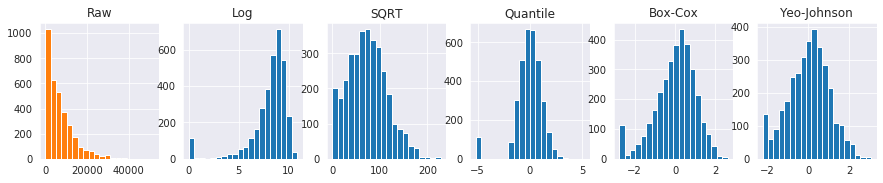

In [15]:
fig, axs = plt.subplots(1,6, figsize=(15,2.5))
axs.ravel()[0].hist(y_train.values, bins=20)

qtrans = QuantileTransformer(output_distribution='normal', random_state=127)
box_cox = PowerTransformer(method='box-cox')
yeo_johnson = PowerTransformer(method='yeo-johnson')

VALS = [y_train.values,
        np.log1p(y_train.values),
        np.sqrt(y_train.values),
        qtrans.fit_transform(y_train.values),
        box_cox.fit_transform(y_train.values + 1e-9),
        yeo_johnson.fit_transform(y_train.values)]

TITLES = ['Raw', 'Log', 'SQRT', 'Quantile', 'Box-Cox', 'Yeo-Johnson']
SHAPIRO_ps = [shapiro(vals)[-1] for vals in VALS]

for i, vals in enumerate(VALS):
    axs.ravel()[i].hist(vals, bins=20)
    axs.ravel()[i].set_title(TITLES[i])
    
plt.show();

In [16]:
# identify the closest to normally-distributed
TITLES[np.array(SHAPIRO_ps).argmax()]

'Yeo-Johnson'

In [17]:
# choose your transformer here
transformer = yeo_johnson

In [19]:
transformer.fit(df[Y_COLS])
y_train, y_test = transformer.transform(y_train), transformer.transform(y_test)

## Split datasets by ecoregion
We want to explore model transferability between regions, so we'll train models independently on subsets of the data within a single ecoregion, as well as a model that is trained on all available ecoregions. 

In [20]:
ecoregions = [reg for reg in pd.unique(df.ecoregion3) if ecoreg_counts.loc[reg]['uuid'] > 20]

eco_train_idx = [x_train.loc[x_train.ecoregion3 == eco].index.values for eco in ecoregions]
eco_test_idx = [x_test.loc[x_test.ecoregion3 == eco].index.values for eco in ecoregions]

eco_xtrain_dfs = [x_train.loc[x_train.ecoregion3 == eco].drop(['ecoregion3'], axis=1) for eco in ecoregions]
eco_ytrain_dfs = [y_train[idx].ravel() for idx in eco_train_idx]
eco_xtest_dfs = [x_test.loc[x_test.ecoregion3 == eco].drop(['ecoregion3'], axis=1) for eco in ecoregions]
eco_ytest_dfs = [y_test[idx].ravel() for idx in eco_test_idx]

# append a "global" model that contains data from all ecoregions
ecoregions.append('all')
ecoregion_names = ['_'.join(x.split('_')[0:2]) for x in ecoregions]
eco_xtrain_dfs.append(x_train.drop(['ecoregion3'], axis=1))
eco_ytrain_dfs.append(y_train.ravel())
eco_xtest_dfs.append(x_test.drop(['ecoregion3'], axis=1))
eco_ytest_dfs.append(y_test.ravel())

## Scoring
We'll use Root Mean Square Error to evaluate model performance.

In [83]:
def rmse(pred, obs):
    # use our transformer to calculate RMSE on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1)).ravel()
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return np.sqrt((np.square(obs-pred)).mean())

In [88]:
def nrmse(pred, obs):
    # use our transformer to calculate percent RMSE on the original data scale
    this_rmse = rmse(pred,obs)
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return this_rmse/obs.mean()

In [81]:
def mae(pred, obs):
    # use our transformer to calculate mean absolute error on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1)).ravel()
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return abs(pred - obs).mean()

In [24]:
def mape(pred, obs):
    # use our transformer to calculate mean average percent error on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1)).ravel()
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return abs(pred - obs).mean() / obs.mean()

In [25]:
def bias(pred, obs):
    # use our transformer to calculate mean bias on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1)).ravel()
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return (pred - obs).mean()

This helper function will calculate RMSE scores for each regionally-trained model and the global model on each ecoregion.

In [78]:
def get_score_df(models, metric=rmse, feature_selectors=None):
    regional_scores = []
    global_scores = []
    counts = []
    
    for i, mod in enumerate(models):
        X_test = x_scaler.transform(eco_xtest_dfs[i])
        if feature_selectors:
            X_test = feature_selectors[i].transform(X_test)
        y_test = eco_ytest_dfs[i].reshape(-1, 1)
        reg_score = metric(mod.predict(X_test), y_test)
        regional_scores.append(reg_score.round(3))
        
        if feature_selectors:
            X_test = x_scaler.transform(eco_xtest_dfs[i])
            X_test = feature_selectors[-1].transform(X_test)
        glob_score = metric(models[-1].predict(X_test), y_test)
        global_scores.append(glob_score.round(3))
        count = len(eco_xtrain_dfs[i] + eco_xtest_dfs[i])
        counts.append(count)
        
    data = list(zip(regional_scores, global_scores, counts))
    res_df = pd.DataFrame(data=data,
                          columns=['regional_model', 'global_model', 'n'],
                          index=ecoregion_names)
    
    return res_df

## Fit some models
For each type of model, we'll employ cross-validation to tune model hyperparameters, generating a tuned model for each ecoregion as well as a tuned model using all training data. We'll work our way through:

#### ElasticNet Regression
Linear model that employs a mix of L1 and L2 regularization to penalize model complexity

#### LASSO Regression  
Linear model that employs L1 regularization to penalize model complexity. We'll also work with a feature-selection process to fit models capped to an explicitly-predefined number of features.

#### K-Nearest Neighbor Regression

#### Random Forest Regression

#### Gradient Boosting Trees Regression

#### Support Vector Machine Regression

## ElasticNet (Linear Model)

In [27]:
best_lms = []

for i in range(len(ecoregions)):
    lm = ElasticNetCV(cv=3, random_state=127, n_jobs=-1, max_iter=1000000)
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i]
    lm.fit(X, y)
    best_lms.append(lm)

In [85]:
elastic_res = get_score_df(best_lms, rmse)
elastic_res

,regional_model,global_model,n
blue_mountains,535.833,573.525,108
coast_range,3686.180,4092.861,1646
eastern_cascades,2439.214,2111.460,403
north_cascades,2556.893,3005.840,490
cascades,3557.109,4016.386,728
klamath_mountains,3832.941,4070.865,321
northern_rockies,1943.508,2153.059,103
puget_lowland,2931.743,3610.768,147
willamette_valley,1524.698,2651.926,43
all,3701.680,3701.680,3355


In [29]:
coefs = np.array([lm.coef_ for lm in best_lms])
count_nonzero = [(~np.isclose(coef, 0, atol=1e-3)).sum() for coef in coefs]
coef_df = pd.DataFrame(data=coefs.T,
                       columns=ecoregions,
                       index=eco_xtest_dfs[i].columns)
coef_df.values[np.isclose(coef_df.values, 0, atol=1e-3)] = np.nan
coef_df = coef_df.round(3)
coef_df = coef_df.dropna(how='all')
coef_df = coef_df.fillna('--')
coef_df.T

,returns_per_m2,strat0_return-proportion,strat1_return-proportion,strat2_return-proportion,strat3_return-proportion,strat4_return-proportion,strat5_return-proportion,strat0_intensity-median,strat1_intensity-median,strat2_intensity-median,...,nffd,bffp,effp,ffp,pas,emt,ext,eref,cmd,rh
blue_mountains,--,-0.064,-0.029,--,0.084,0.122,--,--,--,--,...,--,--,--,--,--,--,--,--,-0.002,--
coast_range,0.001,--,-0.078,-0.003,0.042,0.069,0.11,--,--,-0.035,...,--,--,--,--,--,0.005,--,--,--,0.071
eastern_cascades_slopes_and_foothills,--,--,-0.036,--,--,--,0.059,--,--,-0.029,...,--,--,--,-0.021,--,--,--,--,--,--
north_cascades,0.015,--,-0.122,-0.043,--,0.136,--,-0.047,-0.023,-0.025,...,--,--,--,--,0.081,--,--,--,--,--
cascades,-0.003,-0.094,--,0.007,--,0.068,0.068,0.073,-0.096,-0.014,...,-0.321,--,0.151,--,-0.051,-0.214,--,0.06,--,0.088
klamath_mountains_california_high_north_coast_range,0.007,--,-0.059,--,0.171,0.114,0.427,-0.146,--,-0.047,...,--,0.084,--,--,--,--,-0.081,--,--,0.013
northern_rockies,--,--,-0.157,--,--,--,0.08,--,--,--,...,--,--,--,--,--,--,--,--,--,--
puget_lowland,--,--,-0.196,--,--,--,--,-0.008,--,-0.015,...,--,--,--,--,--,--,--,--,--,--
willamette_valley,--,--,--,-0.095,-0.033,--,0.209,--,--,--,...,--,--,--,--,--,--,--,--,--,--
all,--,--,-0.019,0.05,0.121,0.199,0.399,--,--,-0.059,...,-0.027,--,0.102,--,-0.033,--,-0.122,0.316,0.117,0.16


## LASSO (Linear Model)
Starting with implicit feature selection via L1 regularization of coefficients.

In [30]:
best_lassos = []

for i in range(len(ecoregions)):
    lasso = LassoCV(cv=3, random_state=127, n_jobs=-1, max_iter=1000000, n_alphas=1000)
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i].ravel()
    lasso.fit(X, y)
    best_lassos.append(lasso)

In [31]:
lasso_res = get_score_df(best_lassos)
lasso_res

,regional_model,global_model,n
blue_mountains,541.698,578.094,108
coast_range,3676.925,4090.919,1646
eastern_cascades,2465.652,2100.431,403
north_cascades,2557.669,3004.255,490
cascades,3565.300,4025.752,728
klamath_mountains,3795.338,4074.996,321
northern_rockies,1938.723,2156.156,103
puget_lowland,3034.416,3602.892,147
willamette_valley,1578.843,2646.214,43
all,3701.580,3701.580,3355


In [32]:
coefs = np.array([lm.coef_ for lm in best_lassos])
coef_df = pd.DataFrame(data=coefs.T,
                       columns=ecoregions,
                       index=eco_xtest_dfs[i].columns)
coef_df.values[np.isclose(coef_df.values, 0, atol=1e-3)] = np.nan
coef_df = coef_df.round(3)
coef_df = coef_df.dropna(how='all')
coef_df = coef_df.fillna('--')
coef_df.T

,returns_per_m2,strat0_return-proportion,strat1_return-proportion,strat2_return-proportion,strat3_return-proportion,strat4_return-proportion,strat5_return-proportion,strat0_intensity-median,strat1_intensity-median,strat2_intensity-median,...,nffd,bffp,effp,ffp,pas,emt,ext,eref,cmd,rh
blue_mountains,--,--,--,--,0.059,0.139,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
coast_range,0.001,--,-0.076,--,0.045,0.072,0.115,--,--,-0.036,...,--,--,--,--,--,0.008,--,--,--,0.074
eastern_cascades_slopes_and_foothills,--,--,-0.035,--,--,--,--,--,--,-0.028,...,--,--,--,-0.012,--,--,--,--,--,--
north_cascades,0.015,--,-0.126,-0.044,--,0.143,--,-0.047,-0.018,-0.026,...,--,--,--,--,0.087,--,--,--,--,--
cascades,-0.003,-0.094,--,0.006,--,0.066,0.066,0.072,-0.096,-0.009,...,-0.356,--,0.155,--,-0.055,-0.215,--,0.059,--,0.096
klamath_mountains_california_high_north_coast_range,--,--,-0.061,--,0.185,0.131,0.502,-0.17,--,-0.002,...,--,0.069,--,--,--,--,-0.09,--,--,--
northern_rockies,--,--,-0.161,--,--,--,0.051,--,--,--,...,--,--,--,--,--,--,--,--,--,--
puget_lowland,--,--,-0.217,--,--,--,--,-0.005,--,-0.009,...,--,--,--,--,--,--,--,--,--,--
willamette_valley,--,--,--,-0.062,-0.015,--,0.22,--,--,--,...,--,--,--,--,--,--,--,--,--,--
all,--,--,-0.019,0.053,0.125,0.203,0.409,--,--,-0.058,...,--,--,0.104,--,-0.039,--,-0.128,0.341,0.113,0.164


Now we'll explicitly define the maximum number of features to use for fitting a linear model. We'll trim features by iteratively increasing a threshold for coefficients using LASSO regression

In [33]:
MAX_FEATURES = 5
sfms = [] # transformers that filter X features
trimmed_lassos = [] # re-fit lasso regressions on the subset of the features

for i, lasso in enumerate(best_lassos):
    lasso = deepcopy(lasso)
    sfm = SelectFromModel(lasso, threshold=0.001)
    X = x_scaler.transform(eco_xtrain_dfs[i])
    Y = (eco_ytrain_dfs[i].ravel())
    sfm.fit(X, Y)
    n_features = sfm.transform(X).shape[1]

    # Reset the threshold till the number of features equals two.
    # Note that the attribute can be set directly instead of repeatedly
    # fitting the metatransformer.
    while n_features > MAX_FEATURES:
        sfm.threshold += 0.001
        X_transform = sfm.transform(X)
        n_features = X_transform.shape[1]
    
    sfms.append(sfm)
    try:
        trimmed_lassos.append(lasso.fit(sfm.transform(X), Y))
    except ValueError:
        print(ecoregion_names[i])
        raise
    
trimmed_regional_scores = []
trimmed_global_scores = []
counts = []

for i, lasso in enumerate(trimmed_lassos):
    X_reg = sfms[i].transform(x_scaler.transform(eco_xtest_dfs[i]))
    X_glob = sfms[-1].transform(x_scaler.transform(eco_xtest_dfs[i]))
    observed = eco_ytest_dfs[i]
    
    reg_score = rmse(lasso.predict(X_reg), observed)
    glob_score = rmse(trimmed_lassos[-1].predict(X_glob), observed)
    
    trimmed_regional_scores.append(reg_score.round(3))
    trimmed_global_scores.append(glob_score.round(3))
    
    count = len(eco_xtrain_dfs[i] + eco_xtest_dfs[i])
    counts.append(count)
    

trimmed_lasso_res = pd.DataFrame(data=list(zip(trimmed_regional_scores, trimmed_global_scores, counts)),
                      columns=['regional_model', 'global_model', 'n'],
                      index=ecoregion_names)
trimmed_lasso_res

,regional_model,global_model,n
blue_mountains,551.123,1511.065,108
coast_range,3713.824,6139.897,1646
eastern_cascades,2454.299,3043.323,403
north_cascades,3122.243,4175.658,490
cascades,4156.310,6308.433,728
klamath_mountains,3973.780,5301.788,321
northern_rockies,1897.763,2685.400,103
puget_lowland,3149.208,5154.690,147
willamette_valley,1472.683,3162.867,43
all,5485.094,5485.094,3355


In [34]:
coefs = []
for i in range(len(ecoregions)):
    cols = np.zeros(eco_xtest_dfs[i].columns.shape)
    cols[sfms[i].get_support()] = trimmed_lassos[i].coef_
    coefs.append(cols)
    
coefs = np.array(coefs)

coef_df = pd.DataFrame(data=coefs.T,
                       columns=ecoregions,
                       index=eco_xtest_dfs[i].columns)
coef_df.values[np.isclose(coef_df.values, 0, atol=1e-3)] = np.nan
coef_df = coef_df.round(3)
coef_df = coef_df.dropna(how='all')
coef_df = coef_df.fillna('--')
coef_df.T

,strat1_return-proportion,strat2_return-proportion,strat3_return-proportion,strat4_return-proportion,strat5_return-proportion,height_25-percentile,height_75-percentile,height_95_percentile,height_max,cover,...,plot_size_ac,swir1,swir2,wetness,mwmt,msp,dd_18,nffd,eref,rh
blue_mountains,--,--,0.08,0.194,--,--,--,--,--,0.425,...,--,--,0.103,--,--,--,--,--,--,--
coast_range,-0.217,--,--,--,0.029,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,0.169
eastern_cascades_slopes_and_foothills,--,--,--,--,--,--,0.39,0.18,--,--,...,0.106,--,-0.139,--,-0.127,--,--,--,--,--
north_cascades,-0.265,--,--,0.16,--,--,--,0.528,--,--,...,0.135,--,--,--,--,0.21,--,--,--,--
cascades,--,--,--,--,--,--,--,0.419,-0.397,--,...,--,--,-0.378,--,--,--,--,-0.265,--,--
klamath_mountains_california_high_north_coast_range,--,--,--,--,-0.222,--,1.675,0.912,--,--,...,0.449,--,--,--,--,--,--,--,--,--
northern_rockies,-0.143,--,--,--,0.19,--,0.142,0.113,--,--,...,--,--,--,0.126,--,--,--,--,--,--
puget_lowland,-0.225,--,--,--,--,0.055,0.157,--,--,--,...,--,--,--,--,--,--,--,--,--,--
willamette_valley,--,-0.036,--,--,0.261,--,--,--,--,--,...,0.56,-0.141,--,--,--,--,--,--,--,--
all,--,--,--,--,0.545,--,--,0.894,-0.959,--,...,--,--,--,--,--,--,-0.143,--,-0.027,--


## K-Nearest Neighbors Regression

In [35]:
# Set the parameters by cross-validation
knn_params = {'n_neighbors': [1,2,3,4,5,10,20],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'manhattan']}


knn_gs = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

best_knns = []
for i in range(len(ecoregions)):
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i].ravel()
    knn_gs.fit(X, y)
    best_fit = knn_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y)
    best_knns.append(best_fit)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    2.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    2.6s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.2s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.2s remaining:    0.0s


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s


Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.1s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    1.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.9s finished


In [36]:
knn_res = get_score_df(best_knns)
knn_res

,regional_model,global_model,n
blue_mountains,948.872,864.144,108
coast_range,4007.589,3946.344,1646
eastern_cascades,2769.110,2532.707,403
north_cascades,2677.450,2704.969,490
cascades,4642.995,4336.248,728
klamath_mountains,4163.519,4033.594,321
northern_rockies,2077.030,2050.552,103
puget_lowland,2944.885,3408.915,147
willamette_valley,1242.945,2038.733,43
all,3663.018,3663.018,3355


## Random Forest Regression

In [37]:
# Set the parameters by cross-validation
rf_params = {'n_estimators': [100, 500, 1000, 5000],
             'max_features': ['sqrt'],
             'max_depth': [3, 5, 10, 25, 50],
             'min_samples_leaf': [1,2,4],
             'bootstrap': [True, False]}


rf_gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

best_rfs = []
for i in range(len(ecoregions)):
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i].ravel()
    rf_gs.fit(X, y)
    best_fit = rf_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y)
    best_rfs.append(best_fit)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 297 out of 360 | elapsed:   21.9s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   29.2s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   20.5s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.4min finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   58.5s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   16.0s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.1min finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:   18.5s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.5min finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:   17.4s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   50.6s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   36.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   39.9s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   34.4s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   53.3s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.9min finished


In [38]:
rf_res = get_score_df(best_rfs)
rf_res

,regional_model,global_model,n
blue_mountains,530.504,557.686,108
coast_range,3691.957,3606.644,1646
eastern_cascades,2499.396,2417.853,403
north_cascades,2475.240,2169.712,490
cascades,4113.873,3705.564,728
klamath_mountains,4236.151,4157.528,321
northern_rockies,2066.027,2028.806,103
puget_lowland,2354.432,2533.947,147
willamette_valley,2091.287,2242.739,43
all,3306.285,3306.285,3355


In [39]:
### Employing feature selection to try and improve random forest regression

In [40]:
importances = best_rfs[-1].feature_importances_
indices = np.argsort(importances)[::-1]
features = eco_xtrain_dfs[-1].columns[indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(eco_xtrain_dfs[-1].shape[1]):
    print("%d. %s (%f)" % (f+1, features[f], importances[indices[f]]))

Feature ranking:
1. surface_volume (0.160436)
2. potential_volume (0.111591)
3. height_50-percentile (0.076147)
4. height_75-percentile (0.063859)
5. height_25-percentile (0.052357)
6. cover (0.046603)
7. strat5_return-proportion (0.036113)
8. surface_area_ratio (0.028147)
9. swir2 (0.025395)
10. strat1_return-proportion (0.024233)
11. height_95_percentile (0.023675)
12. stddev_height (0.021268)
13. strat0_return-proportion (0.019702)
14. swir1 (0.019039)
15. height_max (0.013242)
16. wetness (0.013112)
17. plot_size_ac (0.012790)
18. red (0.012192)
19. strat4_return-proportion (0.009981)
20. strat2_return-proportion (0.008458)
21. emt (0.008425)
22. strat3_return-proportion (0.007810)
23. green (0.007756)
24. ndvi (0.007671)
25. savi (0.007164)
26. brightness (0.006979)
27. td (0.006138)
28. strat0_intensity-median (0.006060)
29. strat2_intensity-median (0.005973)
30. strat1_intensity-median (0.005740)
31. strat4_intensity-median (0.005541)
32. blue (0.005441)
33. strat5_intensity-med

## Gradient Boosting Trees Regression

In [41]:
# Set the parameters by cross-validation
gb_params = {'n_estimators': [100, 500, 1000, 5000],
             'learning_rate': [0.01, 0.1],
             'max_depth': [2, 3, 4, 5, 10],
             'max_features': ['sqrt'] 
            }

gb_gs = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=gb_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

best_gbs = []
for i in range(len(ecoregions)):
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i]
    gb_gs.fit(X, y)
    best_fit = gb_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y)
    best_gbs.append(best_fit)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.5s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    4.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   11.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   11.6s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.6s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.1s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    8.6s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    2.3s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.9s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    1.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.9s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.5s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   36.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   37.3s finished


In [42]:
gb_res = get_score_df(best_gbs)
gb_res

,regional_model,global_model,n
blue_mountains,556.084,522.731,108
coast_range,3633.222,3587.327,1646
eastern_cascades,2384.183,2320.407,403
north_cascades,2149.433,2293.399,490
cascades,3899.503,3638.697,728
klamath_mountains,4422.762,4107.796,321
northern_rockies,2167.781,1915.660,103
puget_lowland,2100.025,2524.826,147
willamette_valley,2623.134,2114.033,43
all,3281.584,3281.584,3355


In [43]:
### Employing feature selection to try and improve gradient boosting regression

## Support Vector Machines Regression

In [44]:
# Set the parameters by cross-validation
svm_params = {'kernel': ['linear', 'rbf'],
              'gamma': ['scale', 'auto'],
              'C': [0.1,1,10,100,1000]
              }

svm_gs = GridSearchCV(estimator=SVR(), param_grid=svm_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

best_svms = []
for i in range(len(ecoregions)):
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i]
    svm_gs.fit(X, y)
    best_fit = svm_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y)
    best_svms.append(best_fit)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.9min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    2.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.3min finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.2s remaining:    0.2s


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    2.5s remaining:    2.9s


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    2.4s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   32.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    5.6s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 53.2min finished


In [45]:
svm_res = get_score_df(best_svms)
svm_res

,regional_model,global_model,n
blue_mountains,564.336,495.488,108
coast_range,3593.435,3498.646,1646
eastern_cascades,1935.998,2138.347,403
north_cascades,2495.007,2817.393,490
cascades,4138.272,3749.813,728
klamath_mountains,3626.336,3820.976,321
northern_rockies,1935.917,2131.691,103
puget_lowland,2530.839,2940.981,147
willamette_valley,1834.156,2517.933,43
all,3289.577,3289.577,3355


In [46]:
### Employing feature selection to try and improve support vector regression

In [47]:
MODELS = {'ElasticNet': best_lms, 
          'LASSO': best_lassos,
          'LASSO_{}'.format(MAX_FEATURES): trimmed_lassos,
          'KNN': best_knns,
          'RF': best_rfs,
          'GB': best_gbs,
          'SVM': best_svms}

def scatter_graphs(model_dict):
    names = MODELS.keys()
    EXTEND_PCT = 0.10
    
    fig, axs = plt.subplots(len(ecoregion_names), len(names), 
                            sharex=True, sharey=True,
                            figsize=(12,15)
                           )
    
    all_obs = transformer.inverse_transform(eco_ytest_dfs[-1].reshape(-1,1))
    obs_min = all_obs.min()
    obs_max = all_obs.max()
    rng = obs_max - obs_min
        
    for i, ecoreg in enumerate(ecoregion_names):
        observed = transformer.inverse_transform(eco_ytest_dfs[i].reshape(-1,1))
        
        for j, name in enumerate(names):
            axs[0,j].set_title(name)
            axs[i,0].set_ylabel(ecoreg)
            axs[i,j].set_xlim(obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng)
            axs[i,j].set_ylim(obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng)
            axs[i,j].set_aspect('equal')
            
            if name == 'LASSO_{}'.format(MAX_FEATURES):
                predicted = MODELS[name][-1].predict(sfms[-1].transform(x_scaler.transform(eco_xtest_dfs[i])))
            else:
                predicted = MODELS[name][-1].predict(x_scaler.transform(eco_xtest_dfs[i]))
            
            predicted = transformer.inverse_transform(predicted.reshape(-1,1))
            axs[i,j].scatter(observed, predicted, s=0.5)
            axs[i,j].plot((obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng), 
                          (obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng),
                         color='k', lw=0.5)
            
    plt.tight_layout(pad=0.001)

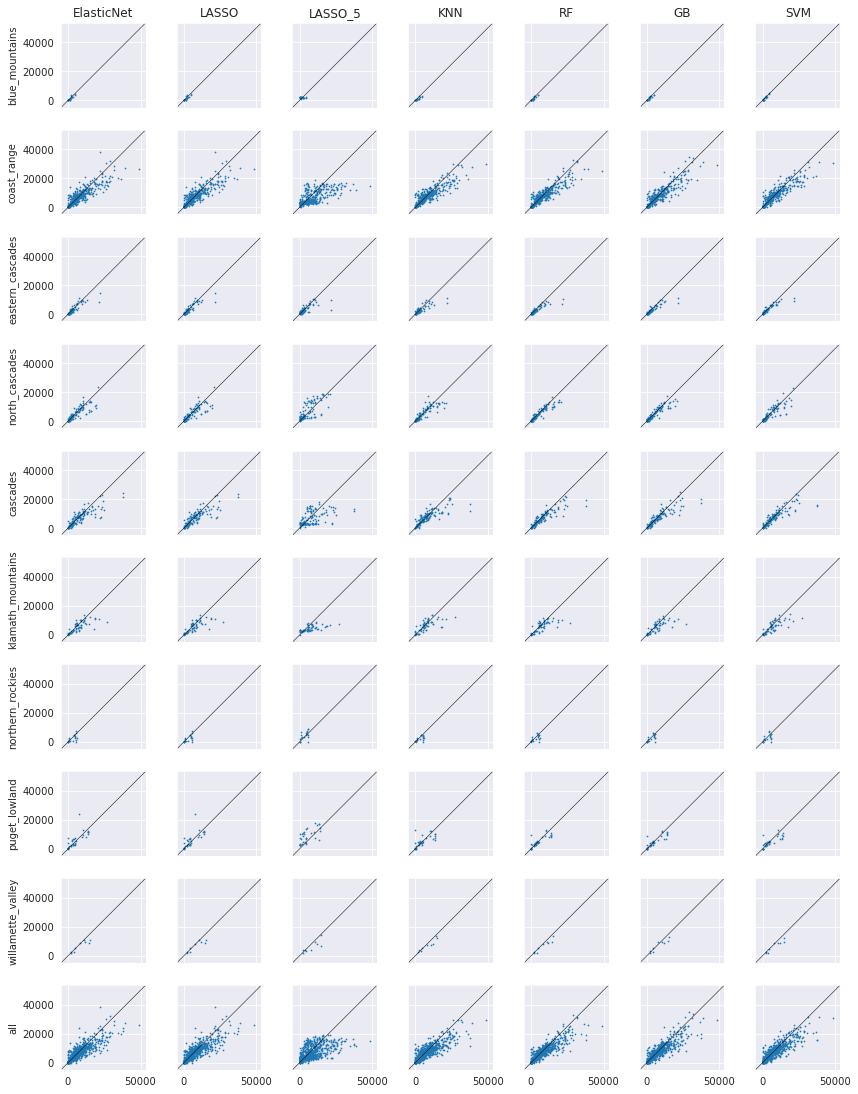

In [48]:
MODELS = {'ElasticNet': best_lms, 
          'LASSO': best_lassos,
          'LASSO_{}'.format(MAX_FEATURES): trimmed_lassos,
          'KNN': best_knns,
          'RF': best_rfs,
          'GB': best_gbs,
          'SVM': best_svms}

scatter_graphs(MODELS)

## View scores for regional and global models

In [49]:
MODEL_NAMES = ['ElasticNet', 'LASSO', 'LASSO_{}'.format(MAX_FEATURES), 'KNN', 'RF', 'GB', 'SVM']
BEST_MODELS = [best_lms, best_lassos, trimmed_lassos, best_knns, best_rfs, best_gbs, best_svms]
    
def compare_models(metric):
    score_dfs = []

    for name, best_models in list(zip(MODEL_NAMES, BEST_MODELS)):
        if name == 'LASSO_{}'.format(MAX_FEATURES):
            score_df = get_score_df(best_models, metric, sfms) 
            score_dfs.append(score_df)
        else:
            score_df = get_score_df(best_models, metric) 
            score_dfs.append(score_df)
        
    counts = np.array(score_dfs[-1]['n'].values)
    regional_data = np.array([df['regional_model'].values for df in score_dfs])
    global_data = np.array([df['global_model'].values for df in score_dfs])
    
    return regional_data, global_data, counts

In [50]:
def highlight_best(s):
    '''
    highlight the closest value to zero in a Series yellow.
    '''
    lowest_idx = abs(s).idxmin()
    return ['background-color: yellow' if idx==lowest_idx else '' for idx in s.index]

In [91]:
print('Regional Models, RMSE')
regional_data, global_data, counts = compare_models(rmse)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(regional_scores
 .style
 .format('{:,.0f}')
 .highlight_min(color='yellow', axis=1, subset=regional_scores.columns[:-1]))

Regional Models, RMSE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,536,542,551,949,531,556,564,108
coast_range,"3,686","3,677","3,714","4,008","3,692","3,633","3,593","1,646"
eastern_cascades_slopes_and_foothills,"2,439","2,466","2,454","2,769","2,499","2,384","1,936",403
north_cascades,"2,557","2,558","3,122","2,677","2,475","2,149","2,495",490
cascades,"3,557","3,565","4,156","4,643","4,114","3,900","4,138",728
klamath_mountains_california_high_north_coast_range,"3,833","3,795","3,974","4,164","4,236","4,423","3,626",321
northern_rockies,"1,944","1,939","1,898","2,077","2,066","2,168","1,936",103
puget_lowland,"2,932","3,034","3,149","2,945","2,354","2,100","2,531",147
willamette_valley,"1,525","1,579","1,473","1,243","2,091","2,623","1,834",43
all,"3,702","3,702","5,485","3,663","3,306","3,282","3,290","3,355"


In [92]:
print('Regional Models, RMSE%')
regional_data, global_data, counts = compare_models(nrmse)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(regional_scores[regional_rmse.columns[:-1]]
 .style
 .format("{:.0%}")
 .highlight_min(color='yellow', axis=1))

Regional Models, RMSE%


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM
blue_mountains,34%,35%,36%,61%,34%,36%,36%
coast_range,43%,43%,44%,47%,43%,43%,42%
eastern_cascades_slopes_and_foothills,68%,69%,69%,78%,70%,67%,54%
north_cascades,46%,46%,56%,48%,44%,38%,44%
cascades,44%,44%,52%,58%,51%,48%,51%
klamath_mountains_california_high_north_coast_range,54%,53%,56%,58%,60%,62%,51%
northern_rockies,61%,61%,60%,66%,65%,68%,61%
puget_lowland,59%,61%,63%,59%,47%,42%,51%
willamette_valley,19%,19%,18%,15%,26%,32%,22%
all,52%,52%,77%,52%,46%,46%,46%


In [73]:
print('Regional Models, Bias')
regional_data, global_data, counts = compare_models(bias)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(regional_scores
 .style
 .format('{:,.0f}')
 .apply(highlight_best, axis=1, subset=regional_rmse.columns[:-1]))

Regional Models, Bias


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,-156,-149,-57,-304,-249,-196,-80,108
coast_range,-346,-336,-395,-577,-611,-584,-103,"1,646"
eastern_cascades_slopes_and_foothills,-567,-566,-428,-821,-610,-432,-308,403
north_cascades,-567,-556,-802,-567,-702,-304,-78,490
cascades,-467,-472,-622,-263,-715,-587,-467,728
klamath_mountains_california_high_north_coast_range,-860,-799,-646,-732,"-1,169","-1,133",-630,321
northern_rockies,-917,-907,-703,-869,"-1,022",-813,-562,103
puget_lowland,-345,-277,-283,-67,-320,6,-370,147
willamette_valley,3,-193,-213,375,506,356,-726,43
all,-520,-519,"-1,005",-516,-612,-514,-450,"3,355"


In [74]:
print('Regional Models, MAE')
regional_data, global_data, counts = compare_models(mae)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(regional_scores
 .style
 .format('{:,.0f}')
 .highlight_min(color='yellow', axis=1, subset=regional_scores.columns[:-1]))

Regional Models, MAE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,390,400,408,596,348,388,402,108
coast_range,"2,438","2,431","2,416","2,640","2,374","2,332","2,338","1,646"
eastern_cascades_slopes_and_foothills,"1,109","1,113","1,200","1,429","1,218","1,199",950,403
north_cascades,"1,536","1,535","1,926","1,670","1,381","1,424","1,493",490
cascades,"2,331","2,338","2,678","2,847","2,263","2,184","2,278",728
klamath_mountains_california_high_north_coast_range,"2,291","2,286","2,707","2,767","2,532","2,676","2,287",321
northern_rockies,"1,411","1,407","1,266","1,411","1,494","1,597","1,398",103
puget_lowland,"2,052","2,115","2,221","2,101","1,428","1,413","1,665",147
willamette_valley,"1,135","1,255","1,271",928,"1,707","1,958","1,632",43
all,"2,310","2,309","3,724","2,262","1,953","1,956","1,969","3,355"


In [55]:
print('Regional Models, MAPE')
regional_data, global_data, counts = compare_models(mape)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(regional_scores[regional_scores.columns[:-1]]
 .style
 .format("{:.0%}")
 .highlight_min(color='yellow', axis=1))

Regional Models, MAPE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM
blue_mountains,25%,26%,26%,38%,22%,25%,26%
coast_range,29%,28%,28%,31%,28%,27%,28%
eastern_cascades_slopes_and_foothills,31%,31%,34%,40%,34%,34%,27%
north_cascades,27%,27%,34%,30%,25%,25%,27%
cascades,29%,29%,33%,35%,28%,27%,28%
klamath_mountains_california_high_north_coast_range,32%,32%,38%,39%,36%,38%,32%
northern_rockies,45%,44%,40%,45%,47%,50%,44%
puget_lowland,41%,42%,44%,42%,29%,28%,33%
willamette_valley,14%,15%,16%,11%,21%,24%,20%
all,32%,32%,52%,32%,27%,28%,28%


In [94]:
print('Global Models, RMSE')
regional_data, global_data, counts = compare_models(rmse)
global_scores = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(global_scores[global_scores.columns[:-1]]
 .style
 .format('{:,.0f}')
 .highlight_min(color='yellow', axis=1))

Global Models, RMSE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM
blue_mountains,574,578,"1,511",864,558,523,495
coast_range,"4,093","4,091","6,140","3,946","3,607","3,587","3,499"
eastern_cascades_slopes_and_foothills,"2,111","2,100","3,043","2,533","2,418","2,320","2,138"
north_cascades,"3,006","3,004","4,176","2,705","2,170","2,293","2,817"
cascades,"4,016","4,026","6,308","4,336","3,706","3,639","3,750"
klamath_mountains_california_high_north_coast_range,"4,071","4,075","5,302","4,034","4,158","4,108","3,821"
northern_rockies,"2,153","2,156","2,685","2,051","2,029","1,916","2,132"
puget_lowland,"3,611","3,603","5,155","3,409","2,534","2,525","2,941"
willamette_valley,"2,652","2,646","3,163","2,039","2,243","2,114","2,518"
all,"3,702","3,702","5,485","3,663","3,306","3,282","3,290"


In [93]:
print('Global Models, RMSE%')
regional_data, global_data, counts = compare_models(nrmse)
global_scores = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(global_scores[global_scores.columns[:-1]]
 .style
 .format("{:.0%}")
 .highlight_min(color='yellow', axis=1))

Global Models, RMSE%


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM
blue_mountains,37%,37%,97%,56%,36%,34%,32%
coast_range,48%,48%,72%,46%,42%,42%,41%
eastern_cascades_slopes_and_foothills,59%,59%,85%,71%,68%,65%,60%
north_cascades,54%,54%,74%,48%,39%,41%,50%
cascades,50%,50%,78%,54%,46%,45%,47%
klamath_mountains_california_high_north_coast_range,57%,57%,74%,57%,58%,58%,54%
northern_rockies,68%,68%,85%,65%,64%,60%,67%
puget_lowland,72%,72%,103%,68%,51%,51%,59%
willamette_valley,32%,32%,39%,25%,27%,26%,31%
all,52%,52%,77%,52%,46%,46%,46%


In [70]:
print('Global Models, Bias')
regional_data, global_data, counts = compare_models(bias)
global_scores = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(global_scores
 .style
 .format('{:,.0f}')
 .apply(highlight_best, axis=1, subset=global_scores.columns[:-1]))

Global Models, Bias


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,-145,-147,379,-454,-216,-128,-34,108
coast_range,-465,-465,"-1,936",-537,-495,-361,-336,"1,646"
eastern_cascades_slopes_and_foothills,-308,-294,-414,-587,-645,-594,-364,403
north_cascades,-389,-394,"1,328",-253,-352,-379,-297,490
cascades,-834,-833,"-1,271",-609,-978,-755,-596,728
klamath_mountains_california_high_north_coast_range,"-1,322","-1,314","-2,611",-760,"-1,398","-1,320","-1,301",321
northern_rockies,-773,-790,"1,046",-841,-439,-514,-308,103
puget_lowland,761,741,"3,527",101,-38,-278,-357,147
willamette_valley,"-1,489","-1,479","-1,822","-1,021","-1,431","-1,064","-1,633",43
all,-520,-519,"-1,005",-516,-612,-514,-450,"3,355"


In [71]:
print('Global Models, MAE')
regional_data, global_data, counts = compare_models(mae)
global_scores = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(global_scores
 .style
 .format('{:,.0f}')
 .highlight_min(color='yellow', axis=1, subset=global_scores.columns[:-1]))

Global Models, MAE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,398,401,"1,306",568,426,411,382,108
coast_range,"2,713","2,712","4,248","2,579","2,314","2,317","2,256","1,646"
eastern_cascades_slopes_and_foothills,"1,108","1,106","1,563","1,385","1,146","1,077",957,403
north_cascades,"1,850","1,852","3,075","1,710","1,374","1,418","1,710",490
cascades,"2,546","2,546","4,487","2,517","1,995","2,006","2,002",728
klamath_mountains_california_high_north_coast_range,"2,537","2,538","3,636","2,661","2,442","2,509","2,497",321
northern_rockies,"1,547","1,546","2,059","1,500","1,501","1,311","1,479",103
puget_lowland,"2,059","2,060","4,329","2,124","1,514","1,525","1,852",147
willamette_valley,"1,839","1,838","2,183","1,585","1,592","1,724","1,883",43
all,"2,310","2,309","3,724","2,262","1,953","1,956","1,969","3,355"


In [60]:
print('Global Models, MAPE')
regional_data, global_data, counts = compare_models(mape)
global_rmse = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregions)
(global_rmse[global_rmse.columns[:-1]]
 .style
 .format("{:.0%}")
 .highlight_min(color='yellow', axis=1))

Global Models, MAPE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM
blue_mountains,26%,26%,84%,36%,27%,26%,25%
coast_range,32%,32%,50%,30%,27%,27%,26%
eastern_cascades_slopes_and_foothills,31%,31%,44%,39%,32%,30%,27%
north_cascades,33%,33%,55%,30%,24%,25%,30%
cascades,32%,32%,56%,31%,25%,25%,25%
klamath_mountains_california_high_north_coast_range,36%,36%,51%,37%,34%,35%,35%
northern_rockies,49%,49%,65%,47%,47%,41%,47%
puget_lowland,41%,41%,87%,43%,30%,31%,37%
willamette_valley,22%,22%,27%,19%,20%,21%,23%
all,32%,32%,52%,32%,27%,28%,28%


In [61]:
METRIC = 'cubic_volume'

MODELS = {'ElasticNet': best_lms,
          'LASSO': best_lassos,
          'LASSO{}'.format(MAX_FEATURES): trimmed_lassos,
          'KNN': best_knns,
          'RF': best_rfs,
          'GB': best_gbs,
          'SVM': best_svms}

pickle.dump(x_scaler, 
            open('../models/{}/sklearn/x_scaler.pkl'.format(METRIC), 'wb'))
pickle.dump(transformer, 
            open('../models/{}/sklearn/y_scaler.pkl'.format(METRIC), 'wb'))

for i in range(len(ecoregion_names)):
    for key in MODELS.keys():
        fname = ecoregion_names[i] + '_{}.pkl'.format(key)
        path_to_file = '../models/{}/sklearn/{}'.format(METRIC, fname)
        pickle.dump(MODELS[key][i], 
                    open(path_to_file, 'wb'))
        
        if key == 'LASSO{}'.format(MAX_FEATURES):
            sfm_name = ecoregion_names[i] + '_LASSO{}_featureselect.pkl'.format(MAX_FEATURES)
            path_to_file = '../models/{}/sklearn/{}'.format(METRIC, sfm_name)
            pickle.dump(sfms[i], 
                        open(path_to_file, 'wb'))